# Reverberation

In [23]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# plt.rcParams['figure.figsize'] = (8, 5)
# plt.rcParams['font.size'] = 14
plt.style.use('ggplot')
# plt.rcParams['figure.facecolor'] = 'white'

# # Reset Matplotlib rcParams to default
# mpl.rcdefaults()
# plt.rcdefaults()
# plt.rcParams.update(plt.rcParamsDefault)
# mpl.RcParams.update(mpl.rcParamsDefault)

# print(mpl.style.available)
# # Reset plt parameters to default
# plt.rcParams.update(plt.rcParamsDefault)

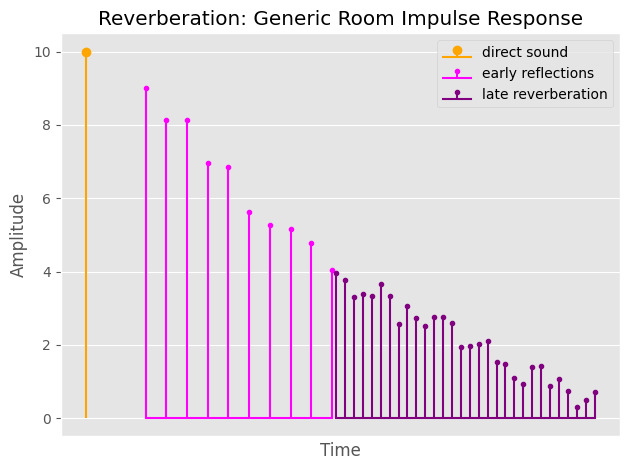

In [24]:
# Generate random offsets for x-values
np.random.seed(42)  # Setting a seed for reproducibility
offset2_x = np.random.uniform(-0.2, 0.2, 10)
offset3_x = np.random.uniform(-0.2, 0.2, 30)

# Define the x-values without offsets
x1 = [0]
x2_without_offsets = np.linspace(350, 1450, 10)
x3_without_offsets = np.linspace(1475, 3000, 30)

# Add offsets to x-values
x2 = x2_without_offsets + offset2_x
x3 = x3_without_offsets + offset3_x

# Create random noise for y-values
noise2 = np.random.normal(0, 0.3, len(x2))
noise3 = np.random.normal(0, 0.3, len(x3))

# Create y-values with noise for each segment
y1 = [10]
y2 = abs(np.linspace(9, 4, 10) + noise2)
y3 = abs(np.linspace(4, 0.25, 30) + noise3)

# Create a stem plot
plt.stem(x1, y1, linefmt='orange', markerfmt='o', basefmt='orange', label='direct sound')
plt.stem(x2, y2, linefmt='magenta', markerfmt='.', basefmt='magenta', label='early reflections')
plt.stem(x3, y3, linefmt='purple', markerfmt='.', basefmt='purple', label='late reverberation')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Reverberation: Generic Room Impulse Response')
plt.xticks([])  # Passing an empty list to hide ticks

# Show the plot
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

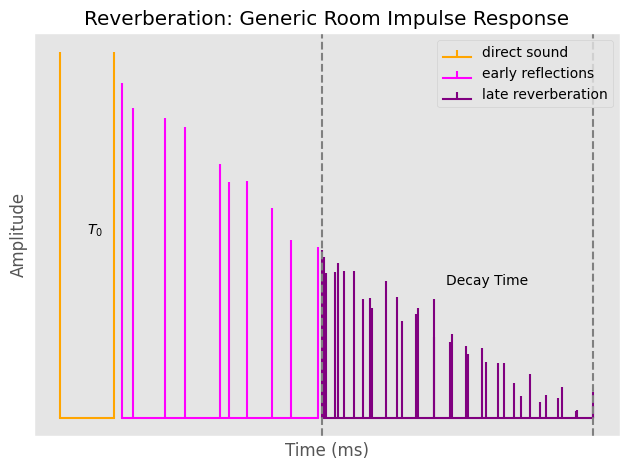

In [25]:
# Define x-values with variations
x1 = [0, 300]

# Create x-values for early reflections with variations
x2_variations = np.array([350, 400, 600, 700, 900, 950, 1050, 1200, 1300, 1450])
x2 = x2_variations + np.random.normal(0, 5, 10)  # Adding random noise for variations

# Create x-values for late reverberation with variations
x3_variations = np.array([1475, 1500, 1550, 1600, 1700, 1750, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000])
x3 = x3_variations + np.random.normal(0, 5, 18)  # Adding random noise for variations

# Double the number of lines in x3
additional_x3_variations = np.linspace(1475, 3000, 18) + np.random.normal(0, 0.3, 18)  # Adding random noise for y-values
x3 = np.concatenate((x3, additional_x3_variations))

# Create random noise for y-values for the additional points in x3
additional_noise3 = np.random.normal(0, 0.3, len(additional_x3_variations))

# Create random noise for y-values for the original x3 points
np.random.seed(42)  # Setting a seed for reproducibility
noise3 = np.random.normal(0, 0.3, len(x3_variations))

# Combine the noise for original x3 points and additional points
y3 = np.concatenate((abs(np.linspace(4.25, 0.25, len(x3_variations)) + noise3),
                     abs(np.linspace(4.25, 0.25, len(additional_x3_variations)) + additional_noise3)))

# Create random noise for y-values of other segments
np.random.seed(42)  # Setting a seed for reproducibility
noise2 = np.random.normal(0, 0.3, len(x2))
y2 = abs(np.linspace(9, 4.5, 10) + noise2)
y1 = [10, 10]

# Create a stem plot
plt.stem(x1, y1, linefmt='orange', markerfmt='', basefmt='orange', label='direct sound')
plt.stem(x2, y2, linefmt='magenta', markerfmt='', basefmt='magenta', label='early reflections')
plt.stem(x3, y3, linefmt='purple', markerfmt='', basefmt='purple', label='late reverberation')

plt.annotate('$T_0$', xy=(150,5))

# Add dashed vertical lines to mark/delimitate the late reverberation
late_reverb_start = x3.min()  # Start of late reverberation
plt.axvline(late_reverb_start, color='gray', linestyle='--')

late_reverb_end = x3[-1]  # End of late reverberation
plt.axvline(late_reverb_end, color='gray', linestyle='--')

# Draw a diagonal line to represent decay time
decay_time_start = (x3[0], y3[0]+0.5)
decay_time_end = (x3[-1], y3[-1]+0.5)
# plt.plot([decay_time_start[0], decay_time_end[0]], [decay_time_start[1], decay_time_end[1]], color='black', label='Decay Time')
plt.annotate('Decay Time', xy=(2400, 3.75), xytext=(2400, 3.75), ha='center', va='center',)

# Place the legend in the upper right corner
plt.legend(loc='upper right')
# Add labels and title
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Reverberation: Generic Room Impulse Response')
plt.xticks([])  # Passing an empty list to hide ticks
plt.yticks([])  # Passing an empty list to hide ticks
# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

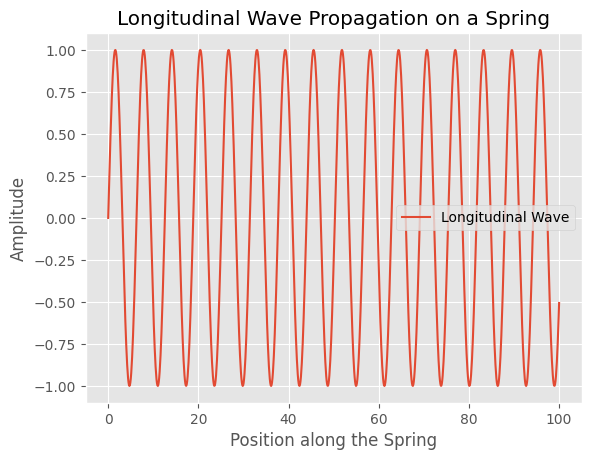

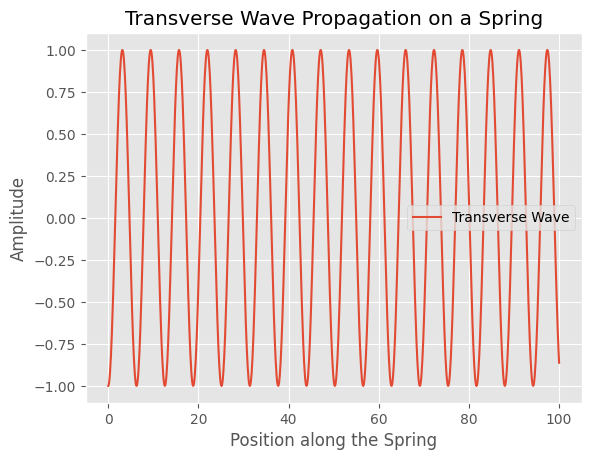

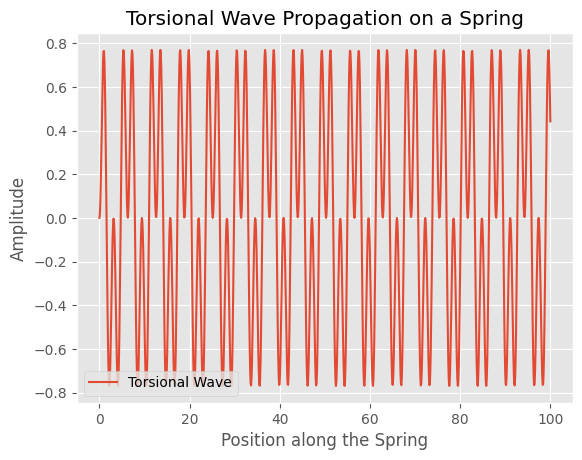

In [26]:
def plot_longitudinal_wave():
    x = np.linspace(0, 100, 1000)
    y = np.sin(x)

    plt.figure()
    plt.plot(x, y, label="Longitudinal Wave")
    plt.title("Longitudinal Wave Propagation on a Spring")
    plt.xlabel("Position along the Spring")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

def plot_transverse_wave():
    x = np.linspace(0, 100, 1000)
    y = np.sin(x - np.pi/2)

    plt.figure()
    plt.plot(x, y, label="Transverse Wave")
    plt.title("Transverse Wave Propagation on a Spring")
    plt.xlabel("Position along the Spring")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

def plot_torsional_wave():
    x = np.linspace(0, 100, 1000)
    y = np.sin(x) * np.sin(2*x)

    plt.figure()
    plt.plot(x, y, label="Torsional Wave")
    plt.title("Torsional Wave Propagation on a Spring")
    plt.xlabel("Position along the Spring")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

# Plotting the waves
plot_longitudinal_wave()
plot_transverse_wave()
plot_torsional_wave()